CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [3]:
import torch

# Check if a CUDA GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use the GPU
else:
    device = torch.device('cpu')  # Use the CPU

CODE BLOCK: 3

In [4]:
import torchvision.transforms as transforms

# Calculate mean and std on your training dataset
data_mean = 0.1307  # Replace with the calculated mean
data_std = 0.3081   # Replace with the calculated standard deviation

train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22)], p=0.5),  # Increased probability
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.RandomHorizontalFlip(),  # Added augmentation
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

test_transforms = transforms.Compose([
    transforms.Resize((28, 28)),  # Added for consistency
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])


CODE BLOCK: 4

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 247863972.22it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41598795.96it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 81719146.83it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17672104.61it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [6]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(test_data, **kwargs)

In [7]:
# Assuming train_loader is defined as in your question (but note the correction needed below)
for data, labels in train_loader:
    print(f"Number of images in batch: {data.size(0)}")
    print(f"Shape of images tensor: {data.shape}")  # [batch_size, channels, height, width]
    print(f"Number of labels in batch: {labels.size(0)}")
    print(f"Shape of labels tensor: {labels.shape}")  # [batch_size]
    break  # Break after the first batch to only print information once


Number of images in batch: 512
Shape of images tensor: torch.Size([512, 1, 28, 28])
Number of labels in batch: 512
Shape of labels tensor: torch.Size([512])


CODE BLOCK: 6

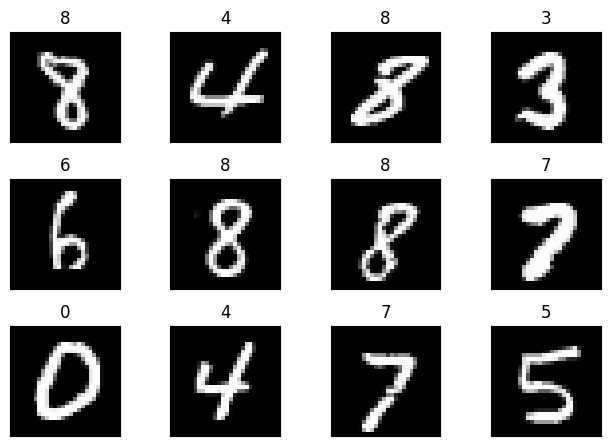

In [8]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [9]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [11]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)  # Correct way to accumulate the test loss
  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.2904 Batch_id=19 Accuracy=13.56: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Test set: Average loss: 2.2834, Accuracy: 2088/10000 (20.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=2.0448 Batch_id=19 Accuracy=39.66: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


Test set: Average loss: 2.0040, Accuracy: 5730/10000 (57.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=2.2933 Batch_id=19 Accuracy=43.81: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Test set: Average loss: 2.2953, Accuracy: 1028/10000 (10.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=2.2468 Batch_id=19 Accuracy=13.17: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Test set: Average loss: 2.2554, Accuracy: 2836/10000 (28.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=2.0798 Batch_id=19 Accuracy=30.74: 100%|██████████| 20/20 [00:02<00:00,  7.27it/s]


Test set: Average loss: 2.0284, Accuracy: 3491/10000 (34.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.6872 Batch_id=19 Accuracy=51.41: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Test set: Average loss: 0.6724, Accuracy: 7851/10000 (78.51%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.4013 Batch_id=19 Accuracy=72.35: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Test set: Average loss: 0.4107, Accuracy: 8802/10000 (88.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.2762 Batch_id=19 Accuracy=90.38: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Test set: Average loss: 0.2355, Accuracy: 9293/10000 (92.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.2640 Batch_id=19 Accuracy=93.63: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Test set: Average loss: 0.1795, Accuracy: 9456/10000 (94.56%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1214 Batch_id=19 Accuracy=95.00: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Test set: Average loss: 0.1378, Accuracy: 9545/10000 (95.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0877 Batch_id=19 Accuracy=95.81: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Test set: Average loss: 0.1145, Accuracy: 9636/10000 (96.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1084 Batch_id=19 Accuracy=96.58: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Test set: Average loss: 0.0944, Accuracy: 9700/10000 (97.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1173 Batch_id=19 Accuracy=96.91: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Test set: Average loss: 0.0851, Accuracy: 9728/10000 (97.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0547 Batch_id=19 Accuracy=97.55: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Test set: Average loss: 0.0726, Accuracy: 9775/10000 (97.75%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0674 Batch_id=19 Accuracy=97.82: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Test set: Average loss: 0.0673, Accuracy: 9772/10000 (97.72%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0484 Batch_id=19 Accuracy=97.89: 100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


Test set: Average loss: 0.0597, Accuracy: 9821/10000 (98.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0477 Batch_id=19 Accuracy=98.25: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Test set: Average loss: 0.0582, Accuracy: 9828/10000 (98.28%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0400 Batch_id=19 Accuracy=98.31: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Test set: Average loss: 0.0573, Accuracy: 9831/10000 (98.31%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0306 Batch_id=19 Accuracy=98.34: 100%|██████████| 20/20 [00:03<00:00,  6.27it/s]


Test set: Average loss: 0.0566, Accuracy: 9833/10000 (98.33%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0552 Batch_id=19 Accuracy=98.28: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Test set: Average loss: 0.0559, Accuracy: 9832/10000 (98.32%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

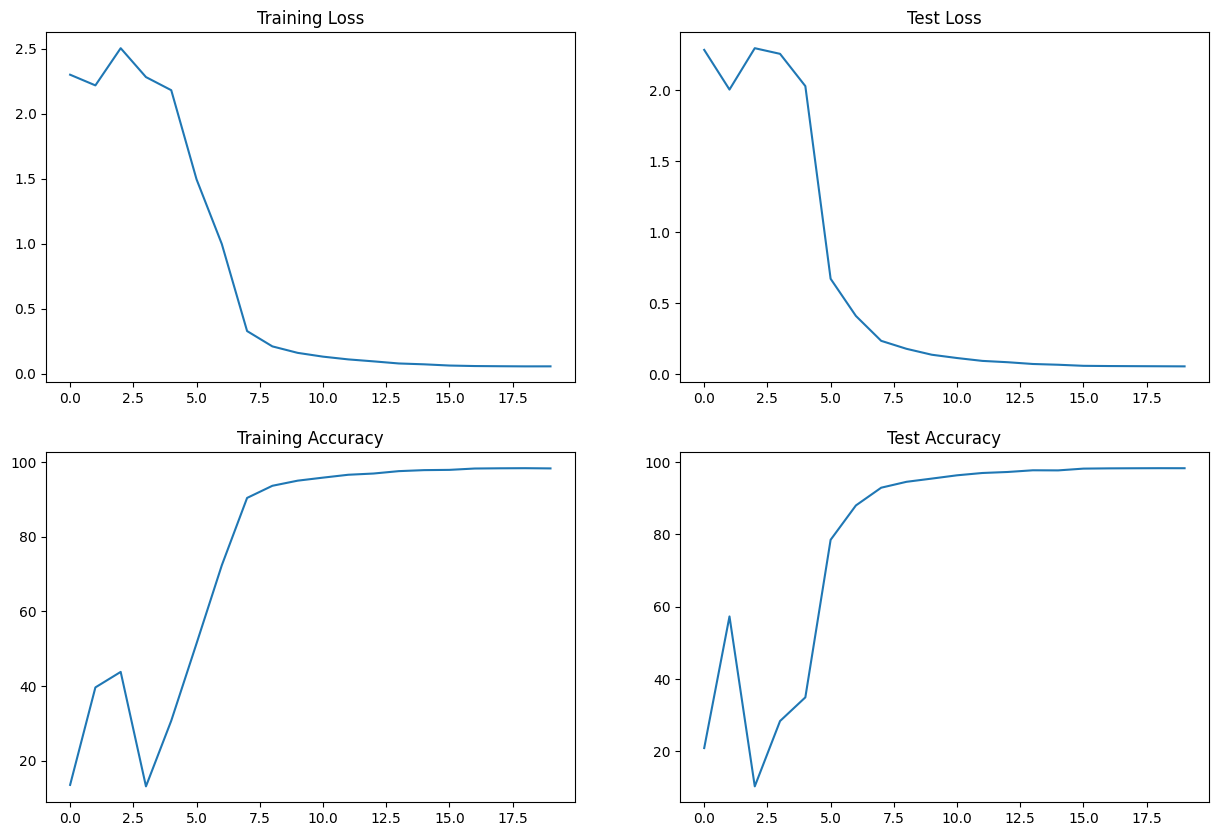

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
